Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
from glob import glob

In [3]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')
##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [4]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [7]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
#Generates a tf.data.Dataset from the image files in the directory.
train_ds = tf.keras.utils.image_dataset_from_directory(
            data_dir_train,
            batch_size=batch_size,
            image_size=(img_height, img_width),
            seed=123,
            validation_split=0.2,
            subset='training',
            )##todo

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [8]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
#Generates a tf.data.Dataset from the image files in the directory.
val_ds = tf.keras.utils.image_dataset_from_directory(
            data_dir_train,
            batch_size=batch_size,
            image_size=(img_height, img_width),
            seed=123,
            validation_split=0.2,
            subset='validation',
            )##todo


Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [9]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

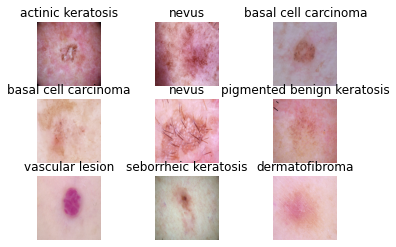

In [10]:
### your code goes here, you can use training or validation data to visualize
import matplotlib.pyplot as plt
for i in range(len(class_names)):
    filtered_ds = train_ds.filter(lambda x, l: tf.math.equal(l[0], i))
    for image, label in filtered_ds.take(1):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(image[i].numpy().astype('uint8'))
        plt.title(class_names[label.numpy()[i]])
        plt.axis('off')

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [12]:
### Your code goes here
#The Keras sequence class helps create a layer cluster that is linearly stacked into a tf. keras. Model.
num_class = 9
model = tf.keras.Sequential([
    layers.Rescaling(scale = 1./255, input_shape = (180,180,3)),
    layers.Conv2D(16,3,padding='same',activation= 'relu'),
    layers.MaxPooling2D(pool_size = 2, strides = 2),    
    layers.Conv2D(32,3,padding='same',activation= 'relu'),
    layers.MaxPooling2D(pool_size = 2, strides = 2),
    layers.Conv2D(64,3,padding='same',activation= 'relu'),
    layers.MaxPooling2D(pool_size = 2, strides = 2),
    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.Dense(num_class)
])

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [13]:
### Todo, choose an appropirate optimiser and loss function
#loss: Sparse Categorical Crossentropy Calculates the crossentropy loss between labels and predictions.
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics=['accuracy'])

In [14]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Train the model

In [15]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 19s 280ms/step - loss: 2.0260 - accuracy: 0.2160 - val_loss: 1.8689 - val_accuracy: 0.3199
Epoch 2/20
56/56 [==============================] - 16s 280ms/step - loss: 1.7434 - accuracy: 0.3616 - val_loss: 1.8780 - val_accuracy: 0.3602
Epoch 3/20
56/56 [==============================] - 16s 282ms/step - loss: 1.5482 - accuracy: 0.4459 - val_loss: 1.4490 - val_accuracy: 0.5190
Epoch 4/20
56/56 [==============================] - 15s 272ms/step - loss: 1.4236 - accuracy: 0.5050 - val_loss: 1.4838 - val_accuracy: 0.4877
Epoch 5/20
56/56 [==============================] - 15s 272ms/step - loss: 1.3058 - accuracy: 0.5346 - val_loss: 1.4297 - val_accuracy: 0.5280
Epoch 6/20
56/56 [==============================] - 15s 272ms/step - loss: 1.2342 - accuracy: 0.5753 - val_loss: 1.3280 - val_accuracy: 0.5570
Epoch 7/20
56/56 [==============================] - 17s 303ms/step - loss: 1.1848 - accuracy: 0.5642 - val_loss: 1.3300 - val_accuracy: 0.5526

### Visualizing training results

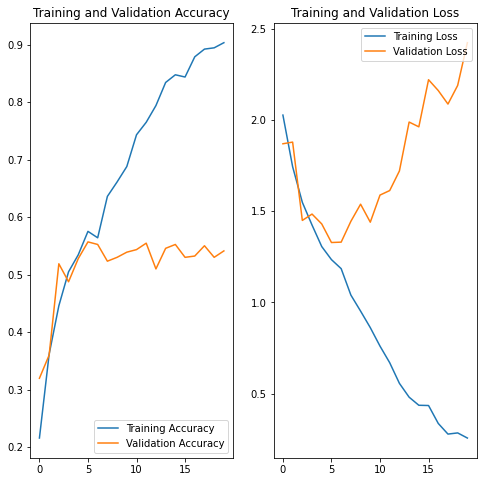

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here
<h2>Findings:-</h2>
<p style="font-size:18px"> The above model is clearly the case of overfitting and the model doesn't seem to be learning anything from the dataset. <br/> 
   &nbsp;&nbsp; (1) Training accuracy is very high, while validation accuracy is around 50%. <br/> 
   &nbsp;&nbsp; (2) The loss on the training set decreases after each epoch, but in the case of the validation set, it climbs back again after the 5th epoch. <br/>
    <br/>
Instead of generalizing and learning real features and general relationships, the model memorized the data</p>

In [17]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
  layers.experimental.preprocessing.RandomZoom(height_factor=(0.2,0.3), width_factor=(0.2,0.3))  
])

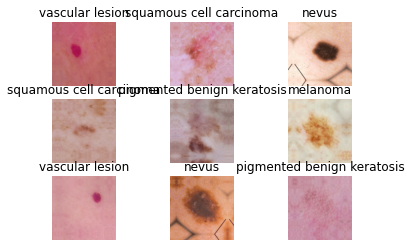

In [18]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
for img, labels in train_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(data_augmentation(img)[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [19]:
## You can use Dropout layer if there is an evidence of overfitting in your findings
## https://www.tensorflow.org/tutorials/images/data_augmentation
## https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/RandomFlip
## Your code goes here
#The Keras sequence class helps create a layer cluster that is linearly stacked into a tf. keras. Model.

num_classes = 9
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.3),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.2),
  layers.Dense(num_classes)
])

### Compiling the model

In [20]:
## Your code goes here

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics=['accuracy'])

### Training the model

In [21]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
) ## your training code

Epoch 1/20
56/56 [==============================] - 25s 364ms/step - loss: 1.9848 - accuracy: 0.2450 - val_loss: 1.9195 - val_accuracy: 0.2998
Epoch 2/20
56/56 [==============================] - 20s 362ms/step - loss: 1.7202 - accuracy: 0.3884 - val_loss: 1.5803 - val_accuracy: 0.4720
Epoch 3/20
56/56 [==============================] - 20s 354ms/step - loss: 1.5701 - accuracy: 0.4503 - val_loss: 1.5929 - val_accuracy: 0.4541
Epoch 4/20
56/56 [==============================] - 20s 356ms/step - loss: 1.5184 - accuracy: 0.4699 - val_loss: 1.4279 - val_accuracy: 0.4966
Epoch 5/20
56/56 [==============================] - 20s 360ms/step - loss: 1.4133 - accuracy: 0.5106 - val_loss: 1.4478 - val_accuracy: 0.4877
Epoch 6/20
56/56 [==============================] - 19s 348ms/step - loss: 1.4091 - accuracy: 0.5061 - val_loss: 1.5145 - val_accuracy: 0.4631
Epoch 7/20
56/56 [==============================] - 20s 355ms/step - loss: 1.4150 - accuracy: 0.5056 - val_loss: 1.3748 - val_accuracy: 0.5369

Epoch 11/20
56/56 [==============================] - 19s 347ms/step - loss: 1.2418 - accuracy: 0.5614 - val_loss: 1.3415 - val_accuracy: 0.5324
Epoch 12/20
56/56 [==============================] - 20s 351ms/step - loss: 1.2402 - accuracy: 0.5692 - val_loss: 1.2949 - val_accuracy: 0.5391
Epoch 13/20
56/56 [==============================] - 20s 349ms/step - loss: 1.2334 - accuracy: 0.5525 - val_loss: 1.3795 - val_accuracy: 0.5101
Epoch 14/20
56/56 [==============================] - 19s 348ms/step - loss: 1.2255 - accuracy: 0.5692 - val_loss: 1.3893 - val_accuracy: 0.5347
Epoch 15/20
56/56 [==============================] - 20s 353ms/step - loss: 1.2422 - accuracy: 0.5681 - val_loss: 1.3519 - val_accuracy: 0.5257
Epoch 16/20
56/56 [==============================] - 20s 365ms/step - loss: 1.1908 - accuracy: 0.5753 - val_loss: 1.3013 - val_accuracy: 0.5369
Epoch 17/20
56/56 [==============================] - 20s 363ms/step - loss: 1.1761 - accuracy: 0.5770 - val_loss: 1.3692 - val_accuracy:

### Visualizing the results

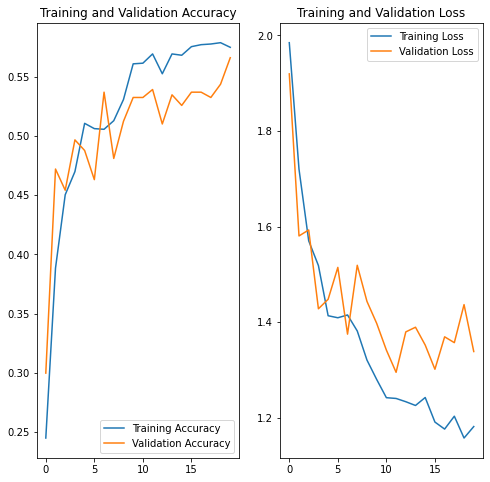

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?
<h2>Findings:-</h2>
<p style="font-size:18px"> In the above model use of data augmentation and dropout layer reduced the problem of overfitting. <br/>
    <br/>The accuracy of the model has greatly increased along with the synchronization of the verification accuracy. The loss function is synchronously exhausted for the training and validation data.</p>

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [23]:
## Your code goes here.
## original_df - > path_list, lesion_list
path_list=[]
lesion_list=[]

In [24]:
for i in class_names:
  for j in data_dir_train.glob(i+'/*.jpg'):
    path_list.append(str(j))
    lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns=['Path','Label'])
original_df

,Path,Label
0,Skin cancer ISIC The International Skin Imagin...,actinic keratosis
1,Skin cancer ISIC The International Skin Imagin...,actinic keratosis
2,Skin cancer ISIC The International Skin Imagin...,actinic keratosis
3,Skin cancer ISIC The International Skin Imagin...,actinic keratosis
4,Skin cancer ISIC The International Skin Imagin...,actinic keratosis
...,...,...
2234,Skin cancer ISIC The International Skin Imagin...,vascular lesion
2235,Skin cancer ISIC The International Skin Imagin...,vascular lesion
2236,Skin cancer ISIC The International Skin Imagin...,vascular lesion
2237,Skin cancer ISIC The International Skin Imagin...,vascular lesion


<BarContainer object of 9 artists>

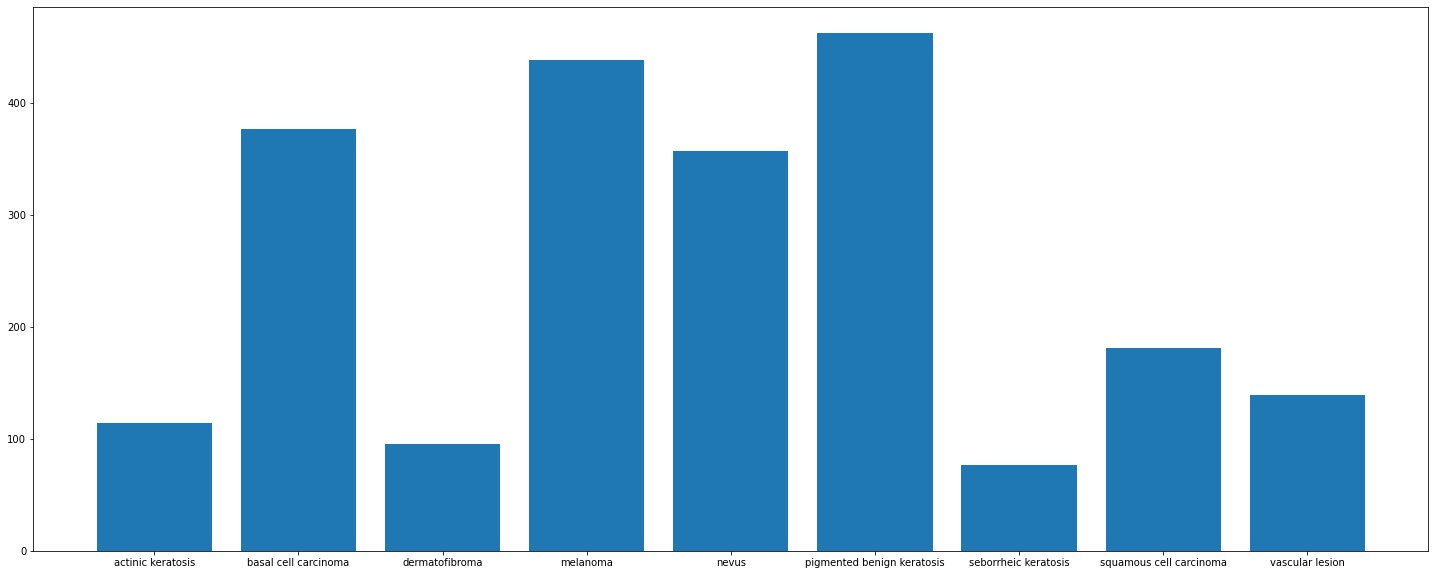

In [25]:
# glob('./Skin cancer ISIC The International Skin Imaging Collaboration/train/*/*')
# './Skin cancer ISIC The International Skin Imaging Collaboration/train\\actinic keratosis\\ISIC_0025780.jpg'
class_count=[]
for i in class_names:
    class_count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(class_names,class_count)

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
<p syle="size:18px">The least number of samples are in seborrheic keratosis</p>

#### - Which classes dominate the data in terms proportionate number of samples?
<p syle="size:18px">The classes dominate in the data are:- 
<br/> * pigmented benign
<br/> * melanoma
<br/>* basal cell carcinoma
<br/>* nevus</p>


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [26]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [27]:
path_to_training_dataset="Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability = 0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x


Initialised with 376 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1918D8C6130>: 100%


Initialised with 95 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1918D8A0A30>: 100%


Initialised with 438 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x1918D8DAAC0>: 100


Initialised with 357 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1918DA4C790>: 100%


Initialised with 462 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1918DF16FD0>: 100%


Initialised with 77 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x1918AAE3CD0>: 100


Initialised with 181 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x


Initialised with 139 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [28]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [29]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_2f871048-2c8a-4e4e-9879-b6ed4b588249.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_58d21c02-95b8-4167-a378-9bcf88c304c2.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_b1ec3521-c0a9-4982-84de-6340fbbebd5b.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_58329269-cbb5-46c9-8f5a-6793b541e139.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_9ad8e92d-e00d-4a61-98ac-c85ec32263b2.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration\\Train

In [30]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [31]:
# 'train/class_name/output/221tews.jpg'.split('/')[-3]

In [32]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [33]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [34]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [35]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [36]:
data_dir_train="Skin cancer ISIC The International Skin Imaging Collaboration/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
                                  data_dir_train,
                                  seed=123,
                                  validation_split = 0.2,
                                  subset = 'training',## Todo choose the correct parameter value, so that only training data is refered to,,
                                  image_size=(img_height, img_width),
                                  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [37]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
                                  data_dir_train,
                                  seed=123,
                                  validation_split = 0.2,
                                  subset = 'validation',## Todo choose the correct parameter value, so that only validation data is refered to,
                                  image_size=(img_height, img_width),
                                  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [38]:
## your code goes here
num_classes = 9
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.3),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.2),
  layers.Dense(num_classes)
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [39]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [40]:
epochs = 30
## Your code goes here, use 50 epochs.
history30 = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)# your model fit code

Epoch 1/30
169/169 [==============================] - 69s 378ms/step - loss: 2.0247 - accuracy: 0.2224 - val_loss: 1.6489 - val_accuracy: 0.3675
Epoch 2/30
169/169 [==============================] - 67s 396ms/step - loss: 1.6232 - accuracy: 0.3804 - val_loss: 1.4281 - val_accuracy: 0.4581
Epoch 3/30
169/169 [==============================] - 64s 376ms/step - loss: 1.4607 - accuracy: 0.4319 - val_loss: 1.3208 - val_accuracy: 0.5041
Epoch 4/30
169/169 [==============================] - 63s 373ms/step - loss: 1.3829 - accuracy: 0.4664 - val_loss: 1.3555 - val_accuracy: 0.4952
Epoch 5/30
169/169 [==============================] - 62s 365ms/step - loss: 1.3044 - accuracy: 0.4961 - val_loss: 1.2324 - val_accuracy: 0.5367
Epoch 6/30
169/169 [==============================] - 62s 367ms/step - loss: 1.2803 - accuracy: 0.5061 - val_loss: 1.2489 - val_accuracy: 0.5271
Epoch 7/30
169/169 [==============================] - 62s 364ms/step - loss: 1.2549 - accuracy: 0.5195 - val_loss: 1.2089 - val_ac

169/169 [==============================] - 64s 378ms/step - loss: 0.8838 - accuracy: 0.6760 - val_loss: 0.9663 - val_accuracy: 0.6288
Epoch 23/30
169/169 [==============================] - 63s 370ms/step - loss: 0.8233 - accuracy: 0.6894 - val_loss: 0.8964 - val_accuracy: 0.6682
Epoch 24/30
169/169 [==============================] - 66s 391ms/step - loss: 0.7899 - accuracy: 0.6984 - val_loss: 0.8601 - val_accuracy: 0.6800
Epoch 25/30
169/169 [==============================] - 65s 381ms/step - loss: 0.7615 - accuracy: 0.7066 - val_loss: 0.8554 - val_accuracy: 0.6689
Epoch 26/30
169/169 [==============================] - 65s 381ms/step - loss: 0.7527 - accuracy: 0.7088 - val_loss: 0.9135 - val_accuracy: 0.6585
Epoch 27/30
169/169 [==============================] - 64s 378ms/step - loss: 0.7415 - accuracy: 0.7090 - val_loss: 0.9260 - val_accuracy: 0.6392
Epoch 28/30
169/169 [==============================] - 63s 372ms/step - loss: 0.7320 - accuracy: 0.7177 - val_loss: 0.8938 - val_accurac

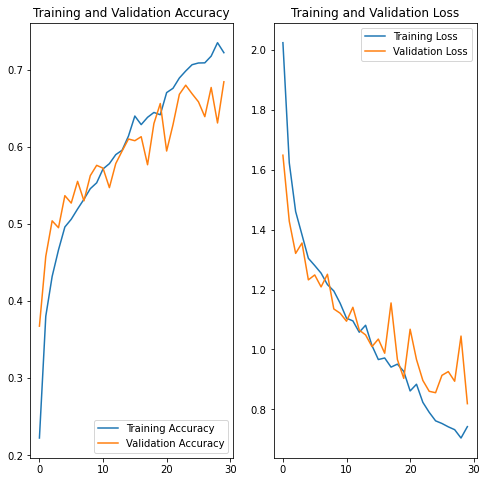

In [41]:
acc = history30.history['accuracy']
val_acc = history30.history['val_accuracy']

loss = history30.history['loss']
val_loss = history30.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?
The problem of overfitting and underfitting was solved and the model was well trained for predictions. Data augmentation, outliers, and class equalization were found to be useful in improving model performance in this case.


#### Train your model for 20 more epochs

In [42]:
epochs = 20
## Your code goes here, use 30 epochs.
history20 = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)# your model fit code

Epoch 1/20
169/169 [==============================] - 64s 380ms/step - loss: 0.6831 - accuracy: 0.7383 - val_loss: 0.9251 - val_accuracy: 0.6570
Epoch 2/20
169/169 [==============================] - 65s 381ms/step - loss: 0.6600 - accuracy: 0.7491 - val_loss: 0.8232 - val_accuracy: 0.7023
Epoch 3/20
169/169 [==============================] - 64s 375ms/step - loss: 0.6607 - accuracy: 0.7448 - val_loss: 0.8645 - val_accuracy: 0.6689
Epoch 4/20
169/169 [==============================] - 63s 372ms/step - loss: 0.6241 - accuracy: 0.7602 - val_loss: 0.9039 - val_accuracy: 0.6652
Epoch 5/20
169/169 [==============================] - 64s 376ms/step - loss: 0.6725 - accuracy: 0.7446 - val_loss: 0.8054 - val_accuracy: 0.7045
Epoch 6/20
169/169 [==============================] - 65s 385ms/step - loss: 0.6182 - accuracy: 0.7630 - val_loss: 1.0566 - val_accuracy: 0.6385
Epoch 7/20
169/169 [==============================] - 64s 380ms/step - loss: 0.5964 - accuracy: 0.7704 - val_loss: 0.8263 - val_ac

#### Visualize the model results for 20 more epochs

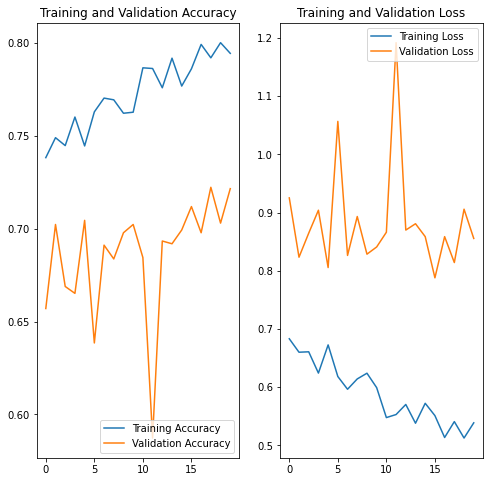

In [43]:
acc = history20.history['accuracy']
val_acc = history20.history['val_accuracy']

loss = history20.history['loss']
val_loss = history20.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Train your model for 50 more epochs

In [44]:
epochs = 50
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)# your model fit code

Epoch 1/50
169/169 [==============================] - 63s 372ms/step - loss: 0.5421 - accuracy: 0.7899 - val_loss: 0.7910 - val_accuracy: 0.7275
Epoch 2/50
169/169 [==============================] - 65s 382ms/step - loss: 0.4756 - accuracy: 0.8194 - val_loss: 0.8492 - val_accuracy: 0.7261
Epoch 3/50
169/169 [==============================] - 63s 373ms/step - loss: 0.5146 - accuracy: 0.8038 - val_loss: 0.7497 - val_accuracy: 0.7506
Epoch 4/50
169/169 [==============================] - 64s 379ms/step - loss: 0.4680 - accuracy: 0.8090 - val_loss: 0.9767 - val_accuracy: 0.6771
Epoch 5/50
169/169 [==============================] - 65s 380ms/step - loss: 0.5014 - accuracy: 0.8049 - val_loss: 0.7702 - val_accuracy: 0.7298
Epoch 6/50
169/169 [==============================] - 65s 383ms/step - loss: 0.4877 - accuracy: 0.8112 - val_loss: 0.8048 - val_accuracy: 0.7335
Epoch 7/50
169/169 [==============================] - 63s 372ms/step - loss: 0.4776 - accuracy: 0.8082 - val_loss: 0.8219 - val_ac

####  Visualize the model results for 50 more epochs

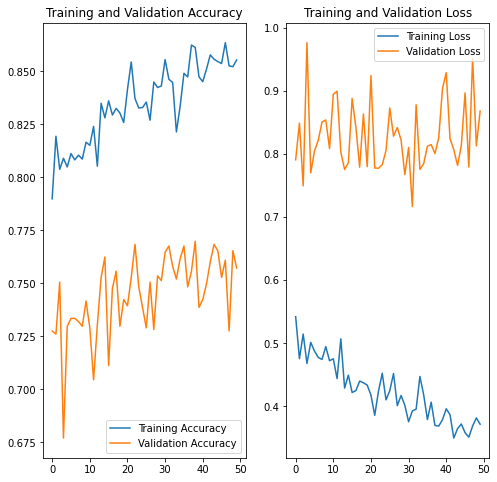

In [45]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()